### References:
* https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization
* http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/
* https://www.kaggle.com/yohanb/lda-visualized-using-t-sne-and-bokeh
* https://github.com/ravishchawla/word_2_vec/blob/master/word_2_vec.ipynb

## Initiliaze

In [11]:
%pylab inline

import pandas as pd
import pickle as pk
import nltk
import re
from scipy import sparse as sp

Populating the interactive namespace from numpy and matplotlib


/Users/austinpowell/Google_Drive/kp_datascience/virtual_envs/nlp-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
%matplotlib inline

import nltk.data;

from gensim.models import word2vec;

from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;

import pandas as pd;
import numpy as np;

import os;
import re;
import logging;
import sqlite3;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;

In [13]:
path_to_data = '../../data/reddit_comments_askDocs_2014_to_2018_03.gz'
df = pd.read_csv(path_to_data,dtype={'body':str,'score_hidden':float})
print('Shape',df.shape)
df.head(2)

/Users/austinpowell/Google_Drive/kp_datascience/virtual_envs/nlp-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape (557648, 21)


,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,...,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,removal_reason
0,for a manlet such as yourself I'd recommend at...,NaN,NaN,NaN,-Ai,This user has not yet been verified.,NaN,1513411674,t5_2xtuc,t3_7k5x2h,...,0,1.514772e+09,0,0,drbt2db,AskDocs,NaN,NaN,default,NaN
1,Thank you very much for answering!,NaN,NaN,NaN,-SY,This user has not yet been verified.,NaN,1445798103,t5_2xtuc,t3_3q697b,...,2,1.447190e+09,0,0,cwcfjpr,AskDocs,2.0,NaN,default,NaN


In [14]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle');

The next function will be called on the comments, and will clean the data. We will apply several pre-processing steps to it.

Remove all escape-tabs and escape-newlines
Remove all non symbol characters (except for the dot)
Normalize spaces to a single character
Remove leading and trailing spaces
Tokenizing the text into sentences
Because it takes a long time to clean the entire comments data, the function has been written to take a file name as an argument. Instead of saving the cleaned text in memory, it will be written to this file instead, to help avoid a kernel crash in case the process runs out of memory.

In [15]:
def clean_text(all_comments, out_name):
    
    out_file = open(out_name, 'w');
    total_rows=len(all_comments)
    print("total_rows:",total_rows)
    for pos in range(len(all_comments)):
        
        #Get the comment
        val = all_comments.iloc[pos]['body'];
        
        #Normalize tabs and remove newlines
        no_tabs = str(val).replace('\t', ' ').replace('\n', '');
        
        #Remove all characters except A-Z and a dot.
        alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs);
        
        #Normalize spaces to 1
        multi_spaces = re.sub(" +", " ", alphas_only);
        
        #Strip trailing and leading spaces
        no_spaces = multi_spaces.strip();
        
        #Normalize all charachters to lowercase
        clean_text = no_spaces.lower();
        
        #Get sentences from the tokenizer, remove the dot in each.
        sentences = tokenizer.tokenize(clean_text);
        sentences = [re.sub("[\.]", "", sentence) for sentence in sentences];
        
        #If the text has more than one space (removing single word comments) and one character, write it to the file.
        if len(clean_text) > 0 and clean_text.count(' ') > 0:
            for sentence in sentences:
                out_file.write("%s\n" % sentence)
        
    out_file.close();

In [16]:
start  = time.time()
clean_comments  = clean_text(df, '../../data/nltk_cleaned_comments.txt')
print('Total time: ' + str((time.time() - start)) + ' secs')

total_rows: 557648
Total time: 564.9033708572388 secs


## Bayesian Word Adjustment
We want to find collocations --- that is, bigrams that are "special" and appear more often than you'd expect from chance. We can think of the corpus as defining an empirical distribution over all ngrams.  We can find word pairs that are unlikely to occur consecutively based on the underlying probability of their words. Mathematically, if $p(w)$ be the probability of a word $w$ and $p(w_1 w_2)$ is the probability of the bigram $w_1 w_2$, then we want to look at word pairs $w_1 w_2$ where the statistic



**Finding $\frac{p(w_1 w_2)}{p(w_1) p(w_2)} $**

In [17]:
%%time
with open('../../data/nltk_cleaned_comments.txt') as f:
    nltk_cleaned_comments = []
    for line in f:
        #inner_list = [elt.strip() for elt in line.split(',')]
        # in alternative, if you need to use the file content as numbers
        # inner_list = [int(elt.strip()) for elt in line.split(',')]
        nltk_cleaned_comments.append(line)
print('Num comments: {}'.format(len(nltk_cleaned_comments)))

# Do some quick cleaning
def clean_text(row):
    import re
    #Normalize tabs and remove newlines
    row = str(row).replace('\t', ' ').replace('\n', ' ');

    #Remove all characters except A-Z and a dot.
    #alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs);

    #Normalize spaces to 1
    row = re.sub(" +", " ", row);
    # She tends to use colons a lot
    row = re.sub(":", " ", row);
    
    # Whitespace at ends
    row = row.strip()

    
    return row

nltk_cleaned_comments = [clean_text(row) for row in nltk_cleaned_comments]

Num comments: 1627612
CPU times: user 21.4 s, sys: 3.22 s, total: 24.7 s
Wall time: 42.1 s


In [18]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
univectorizer = CountVectorizer(stop_words='english',min_df=10,max_df=.96)
bivectorizer = CountVectorizer(stop_words='english',ngram_range=(2,3), min_df = .001,max_df=.96)
unimat = univectorizer.fit_transform(nltk_cleaned_comments)
bimat = bivectorizer.fit_transform(nltk_cleaned_comments)
usum = unimat.sum(axis=0)


CPU times: user 3min 11s, sys: 9.9 s, total: 3min 21s
Wall time: 5min 17s


In [19]:
%%time

ugram_adjustment = 2000

ugrams = {}
for item in univectorizer.vocabulary_.items():
    ugrams[item[0]] = (usum[0,item[1]]+ugram_adjustment)/float(unimat.shape[0])
    
bisum = bimat.sum(axis=0)
bigrams = []
for item in bivectorizer.vocabulary_.items():
    bigrams.append((item[0],bisum[0,item[1]]/float(bimat.shape[0])))

CPU times: user 239 ms, sys: 36.4 ms, total: 275 ms
Wall time: 520 ms


In [20]:
## Optionally delete to save memory
# del bivectorizer
# del bimat
import heapq
heap = []
for i,bigram in enumerate(bigrams):
    word = bigram[0].split(' ')
    try:
        p1 = ugrams[word[0]]
        p2 = ugrams[word[1]]
        den = p1*p2
        val = bigram[1]/den
    except:
        val = 0
    if i<100:
        heapq.heappush(heap,(val,bigram[0]))
    else:
        heapq.heappushpop(heap,(val,bigram[0]))


final_100 = [word[1] for word in heap]
final_100[:40]

['users askdocs best',
 'https wwwredditcom',
 'blood pressure',
 'list information require',
 'list information',
 'information require click',
 'information posts bot',
 'long term',
 'subreddit message',
 'information require',
 'years ago',
 'family history',
 'information posts',
 'heart attack',
 'demographic information posts',
 'faskdocs questions',
 'did abide',
 'removed edits',
 'questions concerns',
 'good luck',
 'removed error message',
 'detailed submissions requirement',
 'error message',
 'removed error',
 'subreddit message compose',
 'makes sense',
 'did abide detailed',
 'abide detailed',
 'link work',
 'urgent care',
 'submit new',
 'work mobile https',
 'moderators subreddit message',
 'true required',
 'link work mobile',
 'primary care',
 'heart rate',
 'questions refer',
 'selftext true required',
 'year old']

In [21]:
start = time.time();

#Set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 200;    # Dimensionality of the hidden layer representation
min_word_count = 40;   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count() -1;       # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       
downsampling = 1e-3   # Downsample setting for frequent words
iterations = 15
sg = 1 # 1 for skip-gram, 0 for cbow

# Initialize and train the model. 
#The LineSentence object allows us to pass in a file name directly as input to Word2Vec,
#instead of having to read it into memory first.

print("Training model...");
model = word2vec.Word2Vec(word2vec.LineSentence('../../data/nltk_cleaned_comments.txt'), workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling,iter=iterations,sg=sg);

# We don't plan on training the model any further, so calling 
# init_sims will make the model more memory efficient by normalizing the vectors in-place.
model.init_sims(replace=True);

# Save the model
model_name = "model_full_reddit";
model.save(model_name);

print('Total time: ' + str((time.time() - start)) + ' secs')

Training model...


2018-08-16 11:12:07,393 : INFO : collecting all words and their counts
2018-08-16 11:12:07,428 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-08-16 11:12:07,561 : INFO : PROGRESS: at sentence #10000, processed 143041 words, keeping 9857 word types
2018-08-16 11:12:07,724 : INFO : PROGRESS: at sentence #20000, processed 278887 words, keeping 14636 word types
2018-08-16 11:12:07,909 : INFO : PROGRESS: at sentence #30000, processed 444433 words, keeping 18844 word types
2018-08-16 11:12:08,140 : INFO : PROGRESS: at sentence #40000, processed 612092 words, keeping 21955 word types
2018-08-16 11:12:08,354 : INFO : PROGRESS: at sentence #50000, processed 771210 words, keeping 24918 word types
2018-08-16 11:12:08,606 : INFO : PROGRESS: at sentence #60000, processed 938508 words, keeping 27703 word types
2018-08-16 11:12:08,831 : INFO : PROGRESS: at sentence #70000, processed 1100804 words, keeping 30157 word types
2018-08-16 11:12:09,033 : INFO : PROGRESS: at 

Total time: 1350.6497490406036 secs


In [22]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means  object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [47]:
Z = model.wv.syn0;
start = time.time()
centers, clusters = clustering_on_wordvecs(Z, 12);
print('Total time: ' + str((time.time() - start)) + ' secs')

/Users/austinpowell/Google_Drive/kp_datascience/virtual_envs/nlp-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


Total time: 5.533643007278442 secs


In [48]:
start = time.time();
centroid_map = dict(zip(model.wv.index2word, clusters));
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 0.004434108734130859 secs


In [49]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;

In [50]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [51]:
top_words = get_top_words(model.wv.index2word, 20, centers, Z);

In [57]:
top_words

,symptoms,blood results,conditions,treatment,emotions,the internet,anatomy,exclamations,health institutions,meds,food,outcomes
1,pounding,ldh,erythematosus,rag,judgmental,ei,humerus,lol,columbia,hydroxyzine,fruit,synthesis
2,dizzy,transferrin,kawasaki,wet,selfish,ved,buttock,yeah,faculty,amitriptyline,berries,weakens
3,lightheaded,electrophoresis,schamberg,waterproof,ignorant,cj,fossa,haha,hospitals,gabapentin,vegetables,mesenchymal
4,shaking,tibc,sarcoidosis,vaseline,snarky,docsgooglecom,ligament,yea,counselors,tramadol,salads,innate
5,faint,sedimentation,guttate,cloth,condescending,cache,sacrum,i,universities,fluticasone,unsweetened,impairs
6,tired,lft,nigricans,clothes,arrogant,deletthis,spermatic,anyway,insurance,promethazine,kale,suppresses
7,breathless,sed,nummular,lotion,uninformed,fiddlejshellnet,underside,so,director,lorazepam,fruits,weakening
8,asleep,hemoglobin,demyelinating,eyelashes,rational,readmemd,ulna,anyways,university,sertraline,celery,peptide
9,disoriented,anca,acanthosis,disinfectant,unfair,convertstometric,protruding,aww,healthcare,omeprazole,avocados,nbds
10,nauseous,haemoglobin,fugax,undies,passionate,postimgorg,vertebra,hehe,facility,zoloft,potatoes,inhibit


In [55]:
top_words.columns = [
    'symptoms',
    'blood results',
    'conditions',
    'treatment',
    'emotions',
    'the internet',
    'anatomy',
    'exclamations',
    'health institutions',
    'meds',
    'food',
    'outcomes'
]

In [29]:
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num).zfill(2)]]))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

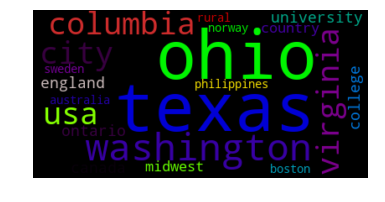

In [42]:
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

for i in range(50):
    col = next(cmaps);
    display_cloud(i+1, col)

In [57]:
def  get_word_table(table, key, sim_key='similarity', show_sim = True):
    if show_sim == True:
        return pd.DataFrame(table, columns=[key, sim_key])
    else:
        return pd.DataFrame(table, columns=[key, sim_key])[key]

In [61]:
get_word_table(model.wv.most_similar_cosmul(positive=['heal'], negative=['pain','stomach']), 'Analogy')

,Analogy,similarity
0,leave,3.332859
1,anyway,3.270688
2,dermatologist,3.260804
3,healing,3.212337
4,clean,3.169578
5,professional,3.097806
6,grow,3.081437
7,cover,3.072386
8,remove,3.061625
9,fungal,3.049295


Although 'heal' is not the first keyword here, some of the other words also fall in the same category.

We can also use Word2Vec to find the word that doesn't match the context of other words in a group.

In [30]:
model.wv.doesnt_match("chronic pain stomach creatinine".split())

/Users/austinpowell/Google_Drive/kp_datascience/virtual_envs/nlp-env/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'creatinine'

In [46]:
keys = ['pain','disease','emergency','thanks','abx','antibiotics','male','female']
tables = [];
for key in keys:
    tables.append(get_word_table(model.wv.similar_by_word(key), key, show_sim=False))
pd.concat(tables, axis=1)

,pain,disease,emergency,thanks,abx,antibiotics,male,female
0,discomfort,diseases,er,thank,antibiotics,abx,female,male
1,pains,lyme,urgent,thx,antibiotic,antibiotic,woman,woman
2,ache,celiac,emergent,thankyou,bactrim,doxycycline,yo,females
3,dull,crohn,department,ty,cipro,azithromycin,caucasian,caucasian
4,radiating,sarcoidosis,emergencies,reply,clindamycin,biotics,men,yo
5,soreness,autoimmune,ambulance,appreciate,amoxicillin,cipro,males,women
6,aching,erythematosus,ed,itthanks,levaquin,flagyl,females,males
7,nausea,parkinson,room,cheers,antifungals,augmentin,old,men
8,headache,alzheimer,hospital,input,vancomycin,amoxicillin,yr,menopausal
9,tightness,sj,emerg,replying,keflex,antifungals,uncircumcised,old


## Multi-dimensional View of Word Vectors

In [32]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    print('Num words: {}'.format(len(model.wv.vocab)))
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = sklearn.manifold.TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(27, 27)) 
    x_offset = 0.2
    y_offset = 1.2
    
    # > 1 spreads items out more, < 1 condenses more
    x_multiplication = 1.01
    y_multiplication = 1.01
    for i in range(len(x)):
        plt.scatter((x[i]*x_multiplication)+x_offset,(y[i]*y_multiplication)+y_offset)
        plt.annotate(labels[i],
                     xy=((x[i]*x_multiplication)+x_offset, (y[i]*y_multiplication)),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig('tsne-plot.png', dpi=199)
    plt.show()

In [34]:
%%time
model2 = word2vec.Word2Vec(word2vec.LineSentence('../../data/nltk_cleaned_comments.txt'), size=200, 
                          sample = 8e-4,   # Downsample setting for frequent words
                          compute_loss=True,
                          window=20, 
                          iter=15,
                          min_count=2000,
                          workers=8)

2018-08-16 12:12:07,896 : INFO : collecting all words and their counts
2018-08-16 12:12:07,907 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-08-16 12:12:08,100 : INFO : PROGRESS: at sentence #10000, processed 143041 words, keeping 9857 word types
2018-08-16 12:12:08,315 : INFO : PROGRESS: at sentence #20000, processed 278887 words, keeping 14636 word types
2018-08-16 12:12:08,628 : INFO : PROGRESS: at sentence #30000, processed 444433 words, keeping 18844 word types
2018-08-16 12:12:08,876 : INFO : PROGRESS: at sentence #40000, processed 612092 words, keeping 21955 word types
2018-08-16 12:12:09,159 : INFO : PROGRESS: at sentence #50000, processed 771210 words, keeping 24918 word types
2018-08-16 12:12:09,360 : INFO : PROGRESS: at sentence #60000, processed 938508 words, keeping 27703 word types
2018-08-16 12:12:09,567 : INFO : PROGRESS: at sentence #70000, processed 1100804 words, keeping 30157 word types
2018-08-16 12:12:09,701 : INFO : PROGRESS: at 

CPU times: user 20min 7s, sys: 21.6 s, total: 20min 28s
Wall time: 16min 54s


Num words: 1209


/Users/austinpowell/Google_Drive/kp_datascience/virtual_envs/nlp-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


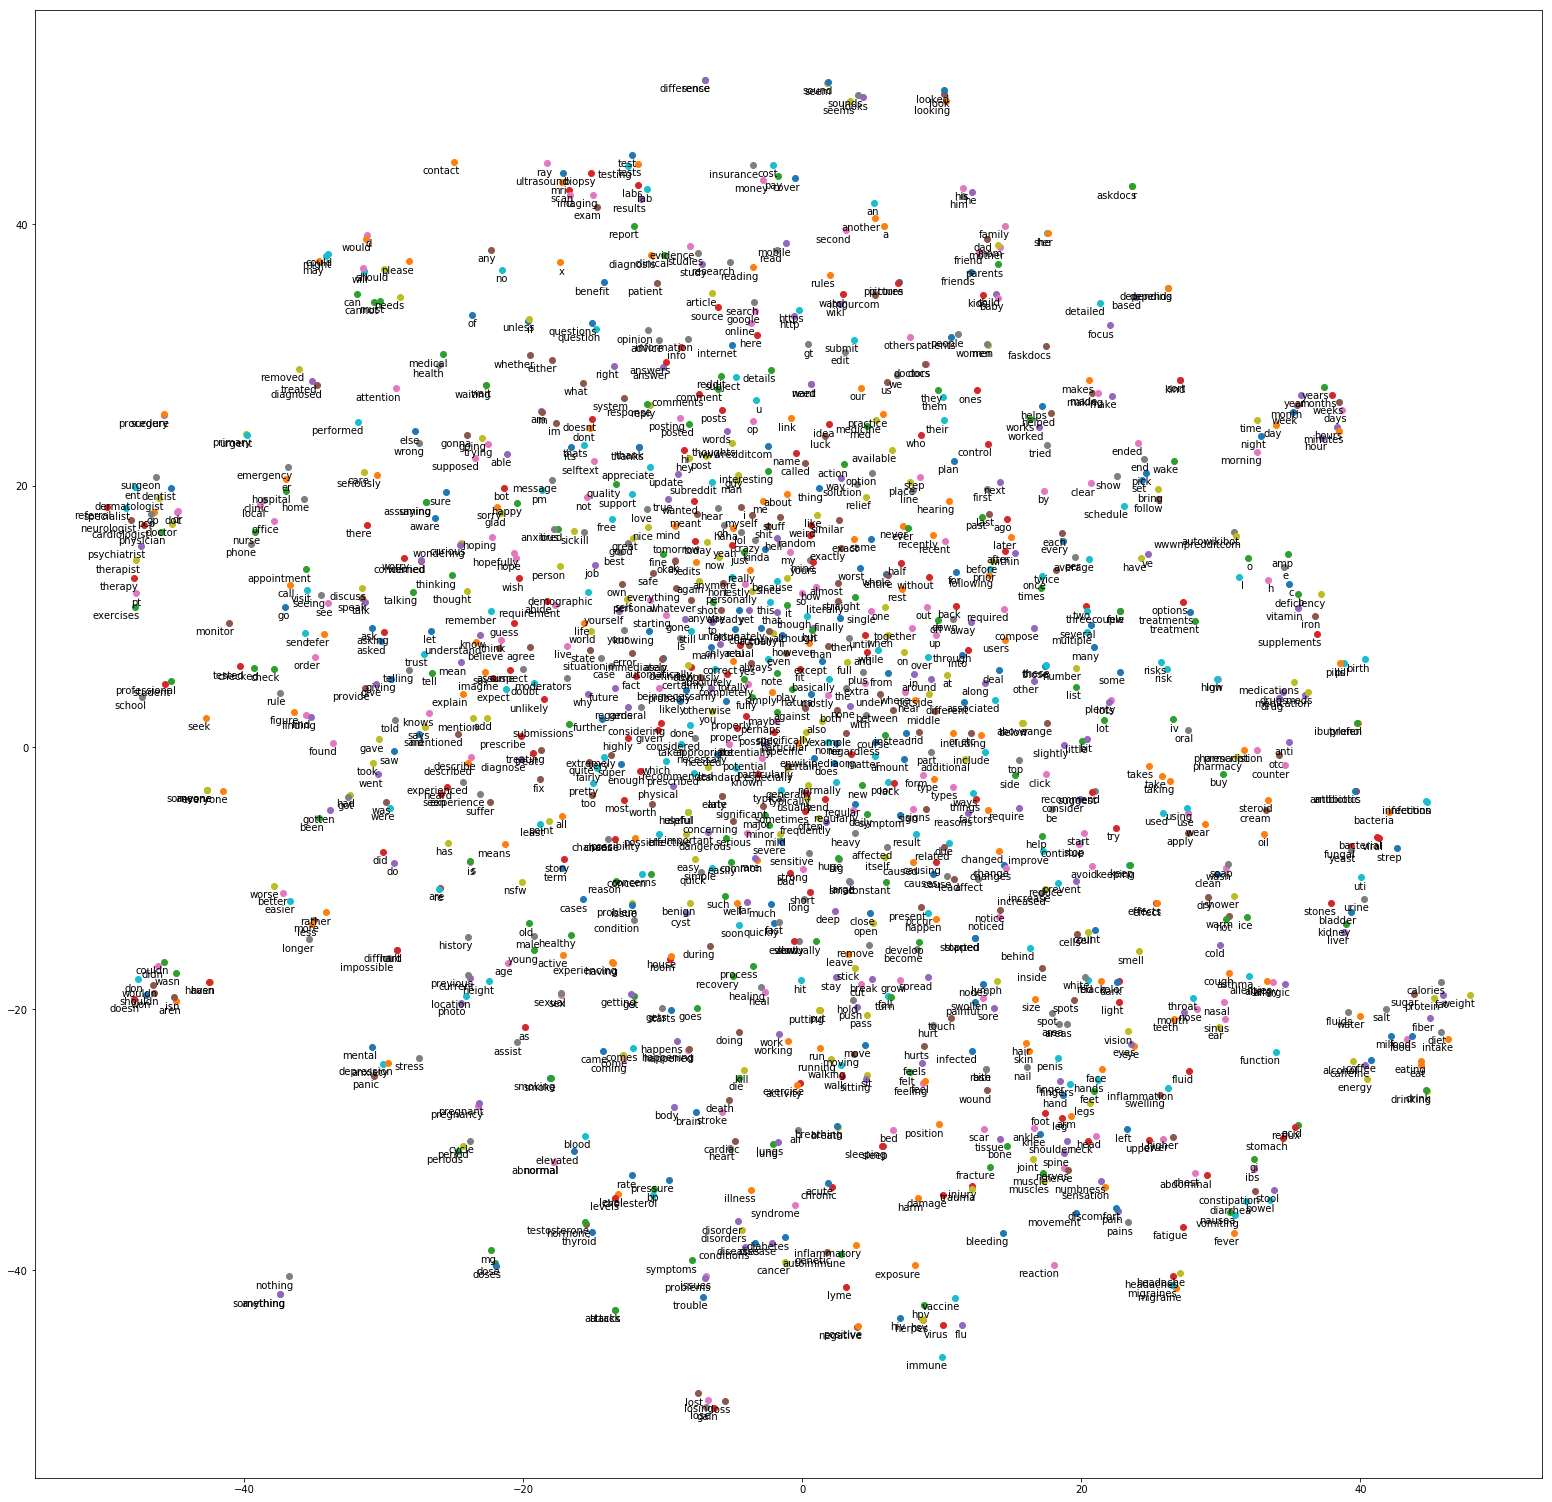

CPU times: user 2min 11s, sys: 12.2 s, total: 2min 24s
Wall time: 3min 55s


In [35]:
%%time
import sklearn
tsne_plot(model2)